# Forecast Police Service Calls

***

## Libraries

In [86]:
import boto3
import sagemaker
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import plotly.express as px

## Variables

In [87]:
db_name = "sdpd"
Bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(Bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
role = sagemaker.get_execution_role()
s3 = boto3.client('s3') # Create an S3 client
s3_resource = boto3.resource('s3') # Create an S3 resource

print('S3_staging_dir - > ',s3_staging_dir)
print('Conn - > ',conn)
print('Region - > ',region)


S3_staging_dir - >  s3://sdpd-bucket/athena/staging
Conn - >  <pyathena.connection.Connection object at 0x7f99e637b290>
Region - >  us-east-1


## Functions

In [88]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=99):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

## Retrive Data

In [89]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'Stops_Hourly'
)

print(Stops_Hourly)

SELECT * FROM sdpd.Stops_Hourly
    order by date_time desc
     LIMIT 1000
     


In [99]:
Stops_Hourly_count = """SELECT count(*) FROM {}.{}
     """.format(
    db_name, 'Stops_Hourly'
)

print(Stops_Hourly_count)

SELECT count(*) FROM sdpd.Stops_Hourly
     


In [90]:
Call_Data = """SELECT * FROM {}.{}
     LIMIT 500
     """.format(
    db_name, 'Call_Data'
)

print(Call_Data)

SELECT * FROM sdpd.Call_Data
     LIMIT 500
     


In [100]:
calls = pd.read_sql(Stops_Hourly_count, conn)
#calls.set_index('date_time', inplace = True)

In [101]:
#calls_ts = calls['count']
calls

,_col0
0,39480


In [93]:
test_size = 100

calls_train = calls[:-test_size]
calls_test = calls[-test_size:]

In [94]:
calls_test

,date_time,count
900,2022-11-24 11:00:00+00:00,4
901,2022-11-24 10:00:00+00:00,12
902,2022-11-24 09:00:00+00:00,8
903,2022-11-24 08:00:00+00:00,14
904,2022-11-24 07:00:00+00:00,12
...,...,...
995,2022-11-20 12:00:00+00:00,10
996,2022-11-20 11:00:00+00:00,17
997,2022-11-20 10:00:00+00:00,11
998,2022-11-20 09:00:00+00:00,5


### Timeseries

In [95]:
plt.title('Airline passengers train and test sets', size=20)
plt.plot(calls_train)
plt.plot(calls_test, color='orange')
plt.legend();

TypeError: unhashable type: 'numpy.ndarray'

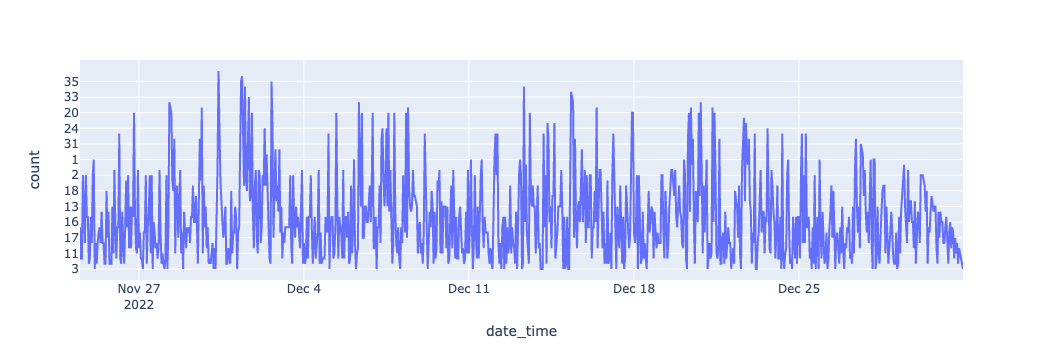

In [96]:
fig = px.line(calls_train, x='date_time', y="count")
fig.show()

In [97]:
fig = sns.lineplot(data=train, x="date_time", y="count")
plt.show()

ValueError: Could not interpret input 'date_time'

In [98]:
decomposition = sm.tsa.seasonal_decompose(x=calls['date_time'], model='additive')
fig = decomposition.plot()
plt.show()

ValueError: could not convert string to float: '2022-12-31 23:00:00+00:00'